# Linear Regression Implementation from Scratch

Now that you understand the key ideas behind linear regression, we can begin to work through a hands-on implementation in code. In this section, we will implement the entire method from scratch, including the data pipeline, the model, the loss function, and the minibatch stochastic gradient descent optimizer. While modern deep learning frameworks can automate nearly all of this work, implementing things from scratch is the only way to make sure that you really know what you are doing. Moreover, when it comes time to customize models, defining our own layers or loss functions, understanding how things work under the hood will prove handy. In this section, we will rely only on tensors and auto differentiation. Afterwards, we will introduce a more concise implementation, taking advantage of bells and whistles of deep learning frameworks.

In [2]:
!pip install torch torchvision

In [5]:
!pip install -U d2l

In [6]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## Generating the Dataset

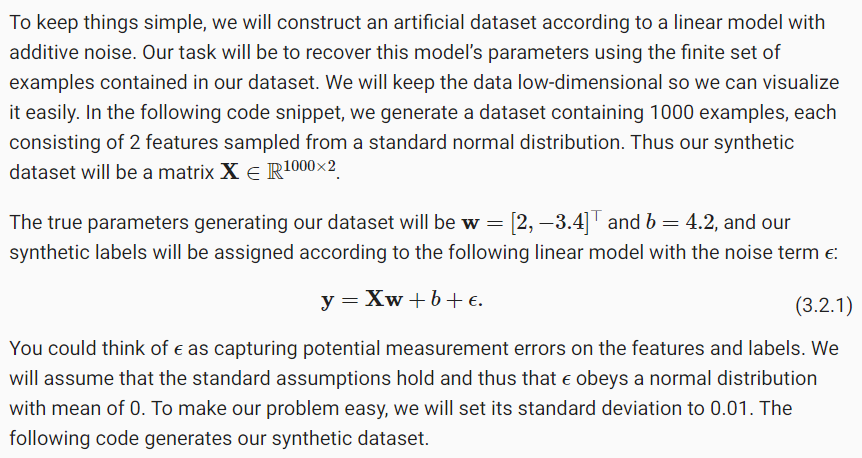

In [8]:
def synthetic_data(w, b, num_examples):  #save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [9]:
# each row in features consists of a 2-dimensional data example and that each row in labels consists of a 1-dimensional label value

print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.0563, -2.1704]) 
label: tensor([11.6726])


In [ ]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

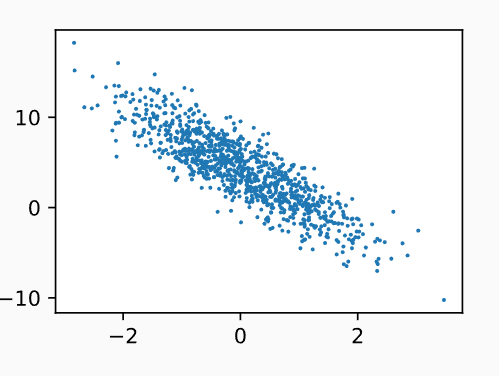

## Reading the Dataset

Recall that training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, it is worth defining a utility function to shuffle the dataset and access it in minibatches.

In the following code, we define the data_iter function to demonstrate one possible implementation of this functionality. The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size. Each minibatch consists of a tuple of features and labels.

In [10]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [11]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1128, -1.0861],
        [ 1.5644,  0.9961],
        [-0.8941, -1.2209],
        [-0.2739, -0.9864],
        [ 0.3949, -0.8147],
        [-0.0616, -0.0599],
        [-1.9007, -1.3445],
        [-1.1719, -0.9834],
        [-0.5868,  0.0134],
        [-0.1544,  0.5711]]) 
 tensor([[5.6608],
        [3.9530],
        [6.5665],
        [7.0192],
        [7.7533],
        [4.2743],
        [4.9673],
        [5.1914],
        [2.9712],
        [1.9499]])


## Initializing Model Parameters

Before we can begin optimizing our model’s parameters by minibatch stochastic gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

In [12]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

After initializing our parameters, our next task is to update them until they fit our data sufficiently well. Each update requires taking the gradient of our loss function with respect to the parameters. Given this gradient, we can update each parameter in the direction that may reduce the loss.

## Defining the Model

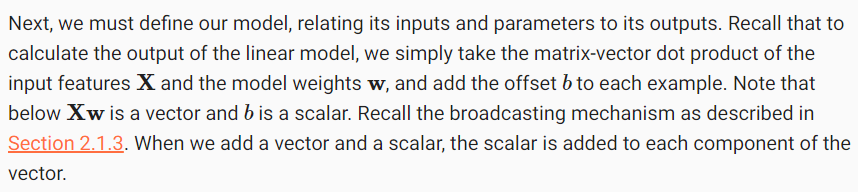

In [14]:
def linreg(X, w, b):  #save
    """The linear regression model."""
    return torch.matmul(X, w) + b

## Defining the Loss Function

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here we will use the squared loss function as described in Section 3.1. In the implementation, we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following function will also have the same shape as y_hat.

In [16]:
def squared_loss(y_hat, y):  #save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Defining the Optimization Algorithm

As we discussed in Section 3.1, linear regression has a closed-form solution. However, this is not a book about linear regression: it is a book about deep learning. Since none of the other models that this book introduces can be solved analytically, we will take this opportunity to introduce your first working example of minibatch stochastic gradient descent.

At each step, using one minibatch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss. The following code applies the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size. The size of the update step is determined by the learning rate lr. Because our loss is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size (batch_size), so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [18]:
def sgd(params, lr, batch_size):  #save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

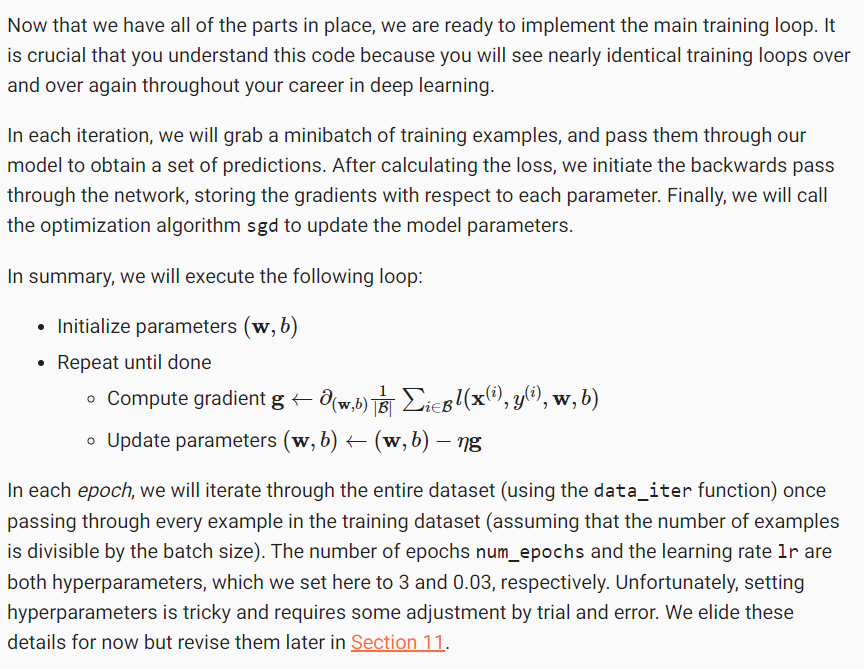

In [19]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.044644
epoch 2, loss 0.000169
epoch 3, loss 0.000049


In [20]:
# because we synthesized the dataset ourselves, we know precisely what the true parameters are
# we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop

print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0003, -0.0004], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0006], grad_fn=<RsubBackward1>)


**Note** that we should not take it for granted that we are able to recover the parameters perfectly. However, in machine learning, we are typically less concerned with recovering true underlying parameters, and more concerned with parameters that lead to highly accurate prediction. Fortunately, even on difficult optimization problems, stochastic gradient descent can often find remarkably good solutions, owing partly to the fact that, for deep networks, there exist many configurations of the parameters that lead to highly accurate prediction.

## Summary

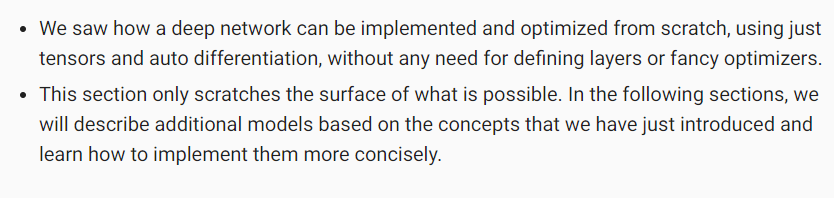